# Introdução

Esse caderno tem por objetivo a criação de um modelo básico de treinamento, utilizando o classificador [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), que faça a predição de homologação de arquivamentos de procedimentos enviados à 1A.CAM do MPF.

Esse modelo usará apenas os metadados dos procedimentos, sem fazer nenhum processamento textual.

O objetivo desse modelo é servir como um *baseline* de comparações para implementações futuras.


**Nota**: os dados desse modelo foram recuperados de procedimentos que tiveram suas deliberações realizadas após o dia 02/07/2018, data em que a nova composição tomou posse na 1A.CAM.

# Carga de dados e pré-processamento

Vamos fazer a carga dos dados e fazer um pré-processamento tradicional (remoção de atributos que não interessam, criação de variáveis categóricas etc.)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

from sklearn import metrics

In [3]:
PATH = "../data/"
df_original = pd.read_json(f'{PATH}/1A.CAM.homologacao-arquivamento.json')

In [4]:
len(df_original)

7917

In [5]:
df_original.columns

Index(['areaAtuacao', 'classe', 'dataAutuacao', 'dataEntrada', 'homologado',
       'id', 'identificadorPecaPromocao', 'itemCnmp', 'membroResponsavel',
       'municipio', 'prioritario', 'procedimento', 'quantidadeConversoes',
       'quantidadeProvidencias', 'textosProvidencias', 'urgente'],
      dtype='object')

In [6]:
df_original.describe()

,areaAtuacao,classe,homologado,id,identificadorPecaPromocao,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,7.917000e+03,7917.000000,7917.000000,7.917000e+03,6.997000e+03,7.917000e+03,6997.000000,7917.000000,7917.000000,7917.000000,7917.000000,7917.000000
mean,2.548770e+02,2.534420,0.984211,6.860230e+07,7.972628e+07,3.423104e+04,38803.358296,2918.129468,0.007326,2.042819,7.221422,0.007705
std,2.247852e+04,1.326541,0.124665,1.342264e+07,6.711927e+06,2.528822e+05,34481.229931,1670.829668,0.085283,1.440170,8.841174,0.087444
min,1.000000e+00,1.000000,0.000000,2.842880e+06,5.580442e+07,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,6.439065e+07,7.442931e+07,1.521000e+03,13674.000000,1443.000000,0.000000,1.000000,2.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,7.111968e+07,8.008322e+07,1.580000e+03,25768.000000,3087.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,7.714450e+07,8.607774e+07,1.904000e+03,53328.000000,4383.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,64.000000,1.000000,8.842176e+07,8.915323e+07,2.007548e+06,128455.000000,5768.000000,1.000000,13.000000,192.000000,1.000000


In [7]:
len(df_original[df_original.identificadorPecaPromocao.isnull()])

920

In [8]:
df_work = df_original.copy()

In [9]:
# elementos com peça de promoção de arquivamento nulos não nos interessam
#df_work.dropna(subset=['identificadorPecaPromocao'], inplace=True)
#df_work.reset_index(drop=True, inplace=True)

In [10]:
#len(df_work[df_work.identificadorPecaPromocao.isnull()])

0

In [9]:
# nessa primeira passada, essas colunas não nos interessam
removed_columns = ['id', 'procedimento', 'textosProvidencias', 'identificadorPecaPromocao']
df_work = df_work.drop(columns=removed_columns)
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
6677,2,3,29-05-2014,24-06-2016,1,1556,64246.0,1301,0,2,10,0
906,2,2,25-05-2018,09-08-2018,1,1503,26496.0,5296,0,1,1,0
5296,2,3,06-05-2014,14-03-2017,1,3147,NaN,3989,0,5,5,0
1374,2,3,30-08-2017,16-07-2018,1,933,14143.0,3708,0,3,5,0
3751,2,2,14-02-2017,27-09-2017,1,1556,127510.0,226,0,2,5,0
3741,5,3,10-11-2015,19-10-2017,1,1864,23247.0,1819,0,3,10,0
3771,2,5,13-12-2016,05-10-2017,1,1556,18182.0,4111,0,0,4,0
5786,2,2,13-07-2016,19-01-2017,1,623,NaN,5459,0,2,8,0
6399,2,2,29-04-2016,23-09-2016,1,1537,20982.0,810,0,1,3,0
5813,2,2,08-07-2016,27-12-2016,1,1106,NaN,3671,0,2,9,0


In [10]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,7.917000e+03,7917.000000,7917.000000,7.917000e+03,6997.000000,7917.000000,7917.000000,7917.000000,7917.000000,7917.000000
mean,2.548770e+02,2.534420,0.984211,3.423104e+04,38803.358296,2918.129468,0.007326,2.042819,7.221422,0.007705
std,2.247852e+04,1.326541,0.124665,2.528822e+05,34481.229931,1670.829668,0.085283,1.440170,8.841174,0.087444
min,1.000000e+00,1.000000,0.000000,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,13674.000000,1443.000000,0.000000,1.000000,2.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,1.580000e+03,25768.000000,3087.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,1.904000e+03,53328.000000,4383.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,64.000000,1.000000,2.007548e+06,128455.000000,5768.000000,1.000000,13.000000,192.000000,1.000000


In [11]:
# tratando os nulos
df_work.fillna(0, inplace=True)

In [12]:
len(df_work[df_work['homologado'] == 1]),len(df_work[df_work['homologado'] == 0])

(7792, 125)

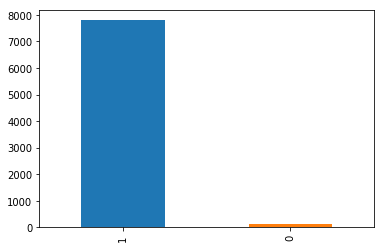

In [13]:
df_work['homologado'].value_counts().plot.bar()

### Classes desbalanceadas!!!

Conforme podemos ver acima, as classes desse problema são altamente desbalanceadas - apenas 1.46% do conjunto de dados representam procedimentos que não foram homologados.

Isso, muito provavelmente, causará problemas no treino do modelo. Mas, inicialmente, vamos ignorar isso e seguir com o nosso treino.

In [14]:
# conversão para datas
df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

In [15]:
# vamos criar uma variável derivada, representando a quantidade de dias desde a autuação até a entrada
df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

In [16]:
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente,diasTranscorridos
5868,2,3,2010-10-28,2016-12-14,1,1581,23774.0,4828,0,5,24,0,2239
3121,2,3,2016-06-20,2018-03-20,1,1532,87588.0,253,0,3,10,0,638
5998,2,2,2015-04-08,2016-11-28,1,1503,22905.0,687,0,2,6,0,600
7236,2,2,2015-12-15,2016-03-18,1,695,4492.0,3113,0,1,3,0,94
2643,2,2,2017-03-14,2018-05-08,1,1503,22992.0,528,0,1,3,0,420
6800,2,3,2014-05-20,2016-06-02,1,1654,2663.0,3113,0,4,27,0,744
2768,2,3,2016-12-07,2018-05-02,1,1689,17136.0,2931,0,1,6,0,511
6356,2,3,2015-03-11,2016-09-28,1,1580,53322.0,2772,0,2,14,0,567
2461,2,2,2017-08-17,2018-05-18,1,3156,127536.0,5,0,2,2,0,274
1145,2,2,2018-04-30,2018-07-24,1,2830,26496.0,5296,0,1,2,0,85


In [50]:
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)
model.fit(df_work[features], df_work['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [51]:
model.score(df_work[features], df_work['homologado'])

0.9983579638752053

In [52]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((5937, 13), (1980, 13))

In [53]:
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [54]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_score():
    print('Accuracy score:', accuracy_score(train['homologado'], train_preds), accuracy_score(valid['homologado'], valid_preds))
    print('Precision score: ', format(precision_score(valid['homologado'], valid_preds)))
    print('Recall score: ', format(recall_score(valid['homologado'], valid_preds)))
    print('F1 score: ', format(f1_score(valid['homologado'], valid_preds)))

print_score()

Accuracy score: 0.9981472123968335 0.9858585858585859
Precision score:  0.9858585858585859
Recall score:  1.0
F1 score:  0.9928789420142421


### Primeira avaliação

Embora não tenha ocorrido overfitting no treinamento e o *score* final tenha sido alto, cabe utilizar uma outra medida para assegurar a qualidade do modelo. Vamos utilizar a ** *matriz de confusão* **.



In [56]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   28],
       [   0, 1952]], dtype=int64)

In [57]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    0, 1952], dtype=int64)

In [58]:
len(valid[valid['homologado']==1]), len(valid[valid['homologado']==0])

(1952, 28)

Ao utilizar o ravel(), temos uma saída do tipo (tn, fp, fn, tp). De onde vemos que:


- tivemos 0 tn - *true negative*; ou seja, o modelo não acertou **nenhum** dos que não tiveram o arquivamento homologado;
- tivemos 28 fp - *false positive*; 28 que não tiveram o arquivamento não homologado e o modelo classificou como homologado;
- tivemos 0 fn - *false negative*; foram homologados e o modelo marcou como não homologados;
- tivemos 1952 tp - *true positive*; foram homologados e o modelo marcou corretamente.

Logo, apesar da acurácia do modelo aparentar ser muito boa (98% no validation set), o **modelo não sabe lidar com os não arquivamentos** - não acertou nenhum dos que realmente não foram homologados. Ou seja dos 28 que não foram homologados, o modelo errou todos.

Fica claro que somente essas features não ajudam na descoberta - o texto da íntegra é, segundo a área negocial, realmente o mais importante.

Vamos continuar avaliando esse modelo.

## Feature importances

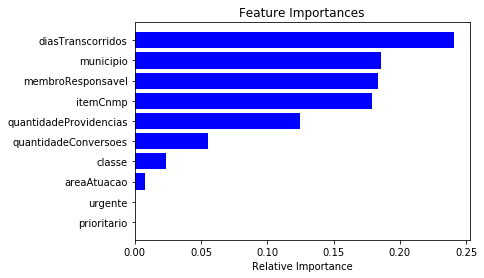

In [59]:
import matplotlib.pyplot as plt

def plot_fi(feature_importances, size=None):
    feature_importances = model.feature_importances_
    
    if not size:
        size = len(feature_importances)
    
    indices = np.argsort(feature_importances[0:size])
    
    plt.title('Feature Importances')
    plt.barh(range(size), feature_importances[indices], color='b', align='center')
    plt.yticks(range(size), [features[i] for i in indices if i < size])
    plt.xlabel('Relative Importance')
    plt.show()
    
plot_fi(model.feature_importances_)

O modelo está dando muita importância ao município que, considerando o bom senso e um pouco de domínio negocial, não faz sentido - o município não deveria interferir.

Lembrar: criar uma coluna para cada uma das listas de palavras-chaves, indicando ausência ou presença

In [62]:
# Vou retirar as colunas com poucas importância
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao', 'urgente', 'prioritario']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9978103419235304 0.9858585858585859
Precision score:  0.9858585858585859
Recall score:  1.0
F1 score:  0.9928789420142421


In [63]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    0, 1952], dtype=int64)

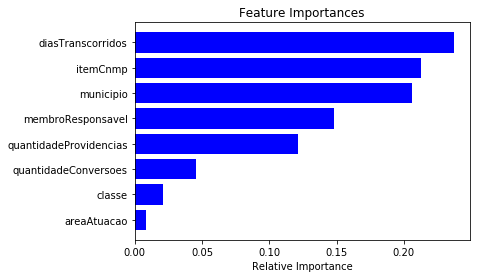

In [64]:
plot_fi(model.feature_importances_)

Com as novas features, retirando a urgente e a prioritário, não houve melhorias.

Vou retirar a coluna município, pois, ao meu ver, ela não nos parece adequada - e o modelo continua dando muita importância a ela.

In [65]:
removed_columns.append('municipio')
removed_columns

features = [c for c in df_work.columns if c not in removed_columns]

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9983156476334849 0.9858585858585859
Precision score:  0.9863498483316482
Recall score:  0.9994877049180327
F1 score:  0.9928753180661578


In [66]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   27],
       [   1, 1951]], dtype=int64)

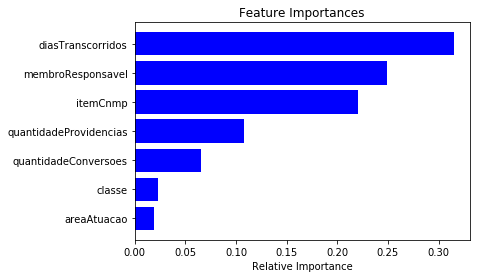

In [67]:
plot_fi(model.feature_importances_)

Ao retirar a coluna município, fez com que aparece um true negative e um false positive.

Vamos criar um modelo ainda mais simples, apenas com as features cuja importância seja maior que 5%.

In [68]:
model = RandomForestClassifier(random_state=42)

important_features = ['membroResponsavel', 'diasTranscorridos', 'itemCnmp', 'quantidadeProvidencias', 'quantidadeConversoes']
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9981472123968335 0.9863636363636363
Precision score:  0.9863567458312279
Recall score:  1.0
F1 score:  0.9931315186975325


In [70]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   27],
       [   0, 1952]], dtype=int64)

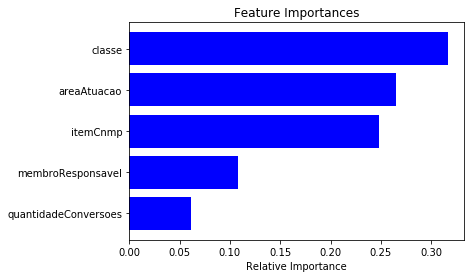

In [71]:
plot_fi(model.feature_importances_)

Somente com as features importantes acima, o desempenho se manteve. 

Interessante notar que a variável diasTranscorridos desapereceu da lista de importâncias.

Vamos fazer mais um teste, apenas com as top-3 features

In [73]:
important_features = ['classe', 'areaAtuacao', 'itemCnmp']

model = RandomForestClassifier(random_state=42)
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9860198753579249 0.9792929292929293
Precision score:  0.9857651245551602
Recall score:  0.9933401639344263
F1 score:  0.9895381474866037


In [74]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   28],
       [  13, 1939]], dtype=int64)

Com o modelo mais simples, a acurácia caiu e apareceram false negatives. 

Fica claro que não sabe lidar com os não homologados.

Vamos passar a considerar o texto das providências.

## Considerando as providências realizadas

In [75]:
df_work = df_original.copy()

df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

removed_columns = ['id', 'procedimento', 'identificadorPecaPromocao', 'prioritario', 'urgente', 'dataAutuacao', 'dataEntrada']
df_work = df_work.drop(columns=removed_columns)
df_work.fillna(0, inplace=True)

    
df_work.sample(10)

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos
1639,2,3,1,1556,127524.0,931,4,11,"Certifica acatamento de recomendação,Notifique...",1425
6596,2,2,1,1857,53253.0,4980,1,1,Converta-se em Procedimento Preparatório(PP).,112
6650,2,2,1,1646,64339.0,3008,2,3,"Oficie-se.,Prorroga-se o prazo de finalização ...",204
5846,2,2,1,1521,0.0,364,2,5,"Oficie-se.,Prorroga-se o prazo de finalização ...",203
212,2,3,1,1102,87480.0,170,1,4,"Converta-se em Inquérito Civil(IC).,Oficie-se....",300
2310,2,3,1,3119,64200.0,3330,3,10,"Converta-se em Inquérito Civil(IC).,Sobrestar ...",658
3411,5,2,1,3119,17164.0,5039,2,2,Prorroga-se o prazo de finalização do Procedim...,131
6393,2,2,1,3056,25743.0,3740,2,2,Prorroga-se o prazo de finalização do Procedim...,266
7849,2,3,1,1861,13117.0,3685,2,5,"Encaminhe-se o auto.,Converta-se em Inquérito ...",467
6134,2,3,1,3147,31458.0,3186,0,4,"Oficie-se,Oficie-se.",388


In [76]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,diasTranscorridos
count,7.917000e+03,7917.000000,7917.000000,7.917000e+03,7917.000000,7917.000000,7917.000000,7917.000000,7917.000000
mean,2.548770e+02,2.534420,0.984211,3.423104e+04,34294.189466,2918.129468,2.042819,7.221422,571.390931
std,2.247852e+04,1.326541,0.124665,2.528822e+05,34719.336036,1670.829668,1.440170,8.841174,604.377912
min,1.000000e+00,1.000000,0.000000,2.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,8883.000000,1443.000000,1.000000,2.000000,172.000000
50%,2.000000e+00,3.000000,1.000000,1.580000e+03,23000.000000,3087.000000,2.000000,5.000000,338.000000
75%,2.000000e+00,3.000000,1.000000,1.904000e+03,53306.000000,4383.000000,3.000000,9.000000,772.000000
max,2.000085e+06,64.000000,1.000000,2.007548e+06,128455.000000,5768.000000,13.000000,192.000000,5823.000000


In [77]:
listaProvidencias = []
for index in range(len(df_work)):
    for s in str(df_work['textosProvidencias'][index]).strip().lower().split(','):
        listaProvidencias.append(s)

listaProvidencias = set(listaProvidencias)
listaProvidencias.remove('análise do arquivamento')
listaProvidencias.remove('analisar arquivamento')
listaProvidencias.remove('arquive-se na unidade.')

In [78]:
df_work = pd.concat([df_work, pd.get_dummies(sorted(list(listaProvidencias)), drop_first=True)], axis=1)

In [79]:
for index in range(len(df_work)):
    for s in str(df_work.textosProvidencias[index]).strip().split(','):
        df_work.at[index, s.lower()] = 1

In [80]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,diasTranscorridos,analisar conflito de atribuição,...,recomende-se.,redistribua-se.,requisite-se perícia à ccr/mpf.,sobrestar no setor.,solicitar instauração de inquérito judicial,vistoria,,analisar arquivamento,arquive-se na unidade.,análise do arquivamento
count,7.917000e+03,7917.000000,7917.000000,7.917000e+03,7917.000000,7917.000000,7917.000000,7917.000000,7917.000000,133.000000,...,667.000000,763.000000,84.000000,969.000000,72.000000,83.000000,163.0,824.0,140.0,217.0
mean,2.548770e+02,2.534420,0.984211,3.423104e+04,34294.189466,2918.129468,2.042819,7.221422,571.390931,0.473684,...,0.904048,0.920052,0.166667,0.939112,0.027778,0.156627,1.0,1.0,1.0,1.0
std,2.247852e+04,1.326541,0.124665,2.528822e+05,34719.336036,1670.829668,1.440170,8.841174,604.377912,0.501195,...,0.294746,0.271390,0.374916,0.239247,0.165489,0.365658,0.0,0.0,0.0,0.0
min,1.000000e+00,1.000000,0.000000,2.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,8883.000000,1443.000000,1.000000,2.000000,172.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
50%,2.000000e+00,3.000000,1.000000,1.580000e+03,23000.000000,3087.000000,2.000000,5.000000,338.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
75%,2.000000e+00,3.000000,1.000000,1.904000e+03,53306.000000,4383.000000,3.000000,9.000000,772.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
max,2.000085e+06,64.000000,1.000000,2.007548e+06,128455.000000,5768.000000,13.000000,192.000000,5823.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0


In [81]:
df_work.head()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos,...,recomende-se.,redistribua-se.,requisite-se perícia à ccr/mpf.,sobrestar no setor.,solicitar instauração de inquérito judicial,vistoria,,analisar arquivamento,arquive-se na unidade.,análise do arquivamento
0,2,2,1,2007044,53327.0,1619,1,1,Converta-se em Procedimento Preparatório(PP).,114,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2,1,1,1904,12958.0,3470,0,1,Encaminhe-se o auto.,149,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2,2,1,1521,31545.0,5160,3,6,"Oficie-se.,Prorroga-se o prazo de finalização ...",311,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2,3,1,1175,64202.0,2351,4,16,"Converta-se em Inquérito Civil(IC).,Sobrestar ...",1475,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2,2,1,2830,5883.0,3689,1,3,"Oficie-se.,Converta-se em Procedimento Prepara...",99,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [82]:
df_work.fillna(0, inplace=True)

In [83]:
removed_columns = ['homologado', 'textosProvidencias']
features = [c for c in df_work.columns if c not in removed_columns]

In [84]:
train, valid = train_test_split(df_work, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [85]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9981472123968335 0.9858585858585859
Precision score:  0.9858585858585859
Recall score:  1.0
F1 score:  0.9928789420142421


In [86]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    0, 1952], dtype=int64)

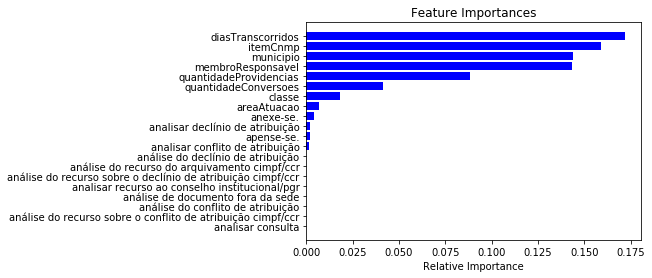

In [87]:
plot_fi(model.feature_importances_, 20)

O uso dos textos das providências não aumentou a precisão do modelo (e elas também não foram features importantes).

Vamos voltar ao modelo mais simples, sem os textos das providências e tentar melhorar os hiperparâmetros.

## Voltando ao modelo mais simples (sem considerar quais providências foram realizadas)

In [54]:
df_work = df_original.copy()

df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

removed_columns = ['id', 'procedimento', 'identificadorPecaPromocao', 'prioritario', 'urgente', 'dataAutuacao', 'dataEntrada']
df_work = df_work.drop(columns=removed_columns)
df_work.fillna(0, inplace=True)

    
df_work.sample(10)

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos
4815,5,2,1,1863,17164.0,5039,1,2,"Oficie-se.,Converta-se em Procedimento Prepara...",73
2863,2,2,1,1521,7980.0,3012,1,3,"Oficie-se,Converta-se em Procedimento Preparat...",88
1818,2,3,1,1503,87584.0,983,5,19,"Despacho Simplificado,Converta-se em Inquérito...",1955
4306,2,2,1,1555,31433.0,4165,2,6,"Desmembre-se.,Certifica acatamento de recomend...",294
3741,2,2,1,2338,15902.0,689,1,1,Converta-se em Procedimento Preparatório(PP).,43
5709,2,3,1,3079,53304.0,1387,1,5,"Converta-se em Inquérito Civil(IC).,Oficie-se.",112
5146,2,2,1,1918,8698.0,3012,1,1,Oficie-se,79
2627,2,3,1,1479,64256.0,2497,4,16,"Despacho Simplificado,Converta-se em Inquérito...",1157
1477,2,2,1,1869,5523.0,3113,2,4,"Oficie-se.,Prorroga-se o prazo de finalização ...",428
5398,2,2,1,1507,87548.0,5152,2,6,"Analisar Arquivamento,Oficie-se.,Prorroga-se o...",560


In [55]:
removed_columns = ['homologado', 'textosProvidencias']
features = [c for c in df_work.columns if c not in removed_columns]

train, valid = train_test_split(df_work, random_state=42)

In [56]:
model = RandomForestClassifier(random_state=42, n_estimators=100); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [57]:
model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 1.0 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [58]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

### Aumentando o número de árvores

In [59]:
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 1.0 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [60]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

In [61]:
model = RandomForestClassifier(random_state=42, n_estimators=1000)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 1.0 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [62]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

In [88]:
model = RandomForestClassifier(random_state=42, n_estimators=2000)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 1.0 0.9858585858585859
Precision score:  0.9858585858585859
Recall score:  1.0
F1 score:  0.9928789420142421


In [89]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    0, 1952], dtype=int64)

Aumentar o número de árvores parece não melhorar a performance. Vamos para o número de features.

### Considerando o número de features

In [90]:
model = RandomForestClassifier(random_state=42); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [91]:
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9981472123968335 0.9858585858585859
Precision score:  0.9858585858585859
Recall score:  1.0
F1 score:  0.9928789420142421


In [92]:
model = RandomForestClassifier(random_state=42, max_features='sqrt')
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9981472123968335 0.9858585858585859
Precision score:  0.9858585858585859
Recall score:  1.0
F1 score:  0.9928789420142421


In [93]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    0, 1952], dtype=int64)

In [94]:
model = RandomForestClassifier(random_state=42, max_features='log2')
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9983156476334849 0.9858585858585859
Precision score:  0.9863498483316482
Recall score:  0.9994877049180327
F1 score:  0.9928753180661578


In [95]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   1,   27,    1, 1951], dtype=int64)

In [96]:
model = RandomForestClassifier(random_state=42, max_features=0.3)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9979787771601819 0.9863636363636363
Precision score:  0.986848760748609
Recall score:  0.9994877049180327
F1 score:  0.9931280223975567


In [98]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   2,   26],
       [   1, 1951]], dtype=int64)

O parâmetro max_features parece não melhorar a performance. Vamos para o min_samples_leaf.

### Checando o min_samples_leaf

In [99]:
model = RandomForestClassifier(random_state=42); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [100]:
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9981472123968335 0.9858585858585859
Precision score:  0.9858585858585859
Recall score:  1.0
F1 score:  0.9928789420142421


In [101]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=2)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9836617820448038 0.9858585858585859
Precision score:  0.9858585858585859
Recall score:  1.0
F1 score:  0.9928789420142421


In [102]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    0, 1952], dtype=int64)

In [103]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=5)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9836617820448038 0.9858585858585859
Precision score:  0.9858585858585859
Recall score:  1.0
F1 score:  0.9928789420142421


In [104]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=10)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9836617820448038 0.9858585858585859
Precision score:  0.9858585858585859
Recall score:  1.0
F1 score:  0.9928789420142421


In [105]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    0, 1952], dtype=int64)

Uma vez mais, não houve melhoria no modelo ao tentar modificar o min_samples_leaf.

Vamos tentar uma última coisa, que é lidar com o fato de as classes serem desbalanceadas.

## Lidando com as classes desbalanceadas

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/